<center>
    <img src="images/personal_logo.png"/>
</center>

# Deep Unsupervised Learning - Final Project
### Juan Carlos Garzon Pico
### Viviane Alves

---

<br>

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/Juank0621)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-Profile-blue?logo=linkedin)](https://www.linkedin.com/in/juancarlosgarzon)
![Python](https://badges.aleen42.com/src/python.svg)

### CelebA SRGAN

We are developing a superresolution AI system using Generative Adversarial Networks (GANs), specifically the SRGAN (Super-Resolution Generative Adversarial Network) model, with the CelebA dataset. In this process, images will first be resized to 128x128, then downscaled to 64x64 to simulate low-resolution images, and finally upscaled back to 128x128 to assess the improvements in image resolution. This approach aims to enhance image quality by restoring high-frequency details and improving the overall clarity of facial images, particularly for applications requiring detailed facial feature analysis.

<center>
    <img src="images/CelebA.png" width="800" />
</center>

In [1]:
# Import necessary libraries
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm.auto import tqdm
from math import log10  

from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

# Set matrix multiplication precision to medium for better performance
torch.set_float32_matmul_precision('medium')

## PyTorch and GPU Information

This code snippet displays the PyTorch version, CUDA version, cuDNN version, and the number of GPUs available for PyTorch.

The first line prints the PyTorch version being used.
The second and third lines retrieve and display the CUDA and cuDNN versions used by PyTorch.
The final line shows the number of GPUs available for PyTorch, helping to confirm whether your system is utilizing the GPU for processing.
This is useful for ensuring that your environment is correctly set up to use GPU acceleration.

In [2]:
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.6.0+cu124


In [3]:
# Get the CUDA version used by PyTorch
cuda_version = torch.version.cuda
print("CUDA Version:", cuda_version)

# Get the cuDNN version used by PyTorch
cudnn_version = torch.backends.cudnn.version()
print("cuDNN Version:", cudnn_version)

CUDA Version: 12.4
cuDNN Version: 90100


In [4]:
# Get the number of GPUs available
num_gpus = torch.cuda.device_count()
print("Num GPUs Available:", num_gpus)

Num GPUs Available: 1


Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that.

In [5]:
!nvidia-smi

Tue Apr 15 08:55:09 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:01:00.0  On |                  N/A |
| 30%   45C    P2              35W / 320W |    901MiB / 16376MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Dataset Directory

Here we define the transformations to be applied to the images in the CIFAR10 dataset.

In [6]:
kwargs = {'num_workers': 8, 'pin_memory': True} # DataLoader optimization for better performance on CUDA.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Generative Adversarial Network (GAN)

## CelebA Dataset for Image Super-Resolution

The CelebA dataset is used for training the model. Images are resized to 128x128, then downscaled to 64x64 to simulate low-resolution inputs. The generator then learns to upscale these low-res images back to 128x128.

### Workflow

1. **Dataset Preparation**: Load the CelebA dataset and preprocess it for low-resolution and high-resolution image pairs.
2. **Model Architecture**: Combine VAE and GAN to create a VAE-GAN model for super-resolution.
3. **Training**: Train the model to generate high-resolution images from low-resolution inputs.
4. **Evaluation**: Use metrics like PSNR and SSIM to evaluate the quality of the generated images.

<center>
    <img src="images/CelebA1.png" width="800" />
</center>

In [8]:
transform_hr = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 for high-res images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

transform_lr = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64 for low-res images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

In [9]:
# Define the CelebA dataset class
class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform_hr=None, transform_lr=None):
        """
        Custom dataset class for loading CelebA images.

        Args:
            image_paths (list): List of image file paths.
            transform_hr (callable, optional): Transformation for high-resolution images.
            transform_lr (callable, optional): Transformation for low-resolution images.
        """
        self.image_paths = image_paths  # List of image file paths
        self.transform_hr = transform_hr  # Transformation for high-resolution images
        self.transform_lr = transform_lr  # Transformation for low-resolution images

    def __getitem__(self, idx):
        """
        Retrieve a high-resolution and low-resolution image pair.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            tuple: High-resolution and low-resolution images as tensors.
        """
        # Open the image at the given index
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')  # Open image and convert to RGB
        
        # Apply transformations for HR and LR images (convert to tensor)
        hr_img = self.transform_hr(img) if self.transform_hr else transforms.ToTensor()(img)
        lr_img = self.transform_lr(img) if self.transform_lr else transforms.ToTensor()(img)
        
        return hr_img, lr_img  # Return HR and LR images as tensors

    def __len__(self):
        """
        Get the total number of images in the dataset.

        Returns:
            int: Total number of images.
        """
        return len(self.image_paths)

In [10]:
# Split dataset into train and test sets
def split_dataset(root, test_ratio=0.2):
    """
    Split the dataset into training and testing sets.

    Args:
        root (str): Path to the dataset directory containing images.
        test_ratio (float): Proportion of the dataset to use for testing.

    Returns:
        tuple: Paths for training and testing datasets.
    """
    image_paths = [os.path.join(root, img) for img in os.listdir(root) if img.endswith('.jpg')]
    split_idx = int(len(image_paths) * (1 - test_ratio))
    train_paths = image_paths[:split_idx]
    test_paths = image_paths[split_idx:]
    return train_paths, test_paths

### DataLoader

In [11]:
# Paths to the dataset
dataset_root = './data/celeba'
train_paths, test_paths = split_dataset(dataset_root)

In [12]:
# Create train and test datasets
train_dataset = CelebADataset(train_paths, transform_hr=transform_hr, transform_lr=transform_lr)
test_dataset = CelebADataset(test_paths, transform_hr=transform_hr, transform_lr=transform_lr)


In [13]:
# Display the number of images in the training and testing datasets
print(f"Number of images in the training dataset: {len(train_dataset)}")
print(f"Number of images in the testing dataset: {len(test_dataset)}")

Number of images in the training dataset: 162079
Number of images in the testing dataset: 40520


In [14]:
# Create DataLoaders for train and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, **kwargs)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, **kwargs)

In [15]:
for hr_real, lr_real in train_dataloader:
    print("High-resolution shape:", hr_real.shape)  # Should print: (16, 3, 128, 128)
    print("Low-resolution shape:", lr_real.shape)  # Should print: (16, 3, 64, 64)
    break  

High-resolution shape: torch.Size([16, 3, 128, 128])
Low-resolution shape: torch.Size([16, 3, 64, 64])


In [16]:
def show_images(images_real, images_transformed, ncols=5, nrows=2):
    def denormalize(img):
        """
        Denormalizes an image from the range [-1, 1] to the range [0, 1].
        """
        return (img * 0.5) + 0.5  # Reverse normalization

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(ncols * nrows):
        if i < 10:
            img = denormalize(images_real[i]).numpy().transpose(1, 2, 0)  # Denormalize and convert to HWC
        else:
            img = denormalize(images_transformed[i - 10]).numpy().transpose(1, 2, 0)  # Denormalize and convert to HWC
        
        axes[i].imshow(img)
        #axes[i].axis('off')

        # Adjust axis ticks
        axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))  # Integer ticks on x-axis
        axes[i].yaxis.set_major_locator(MaxNLocator(integer=True))  # Integer ticks on y-axis
    
    plt.tight_layout()
    plt.show()

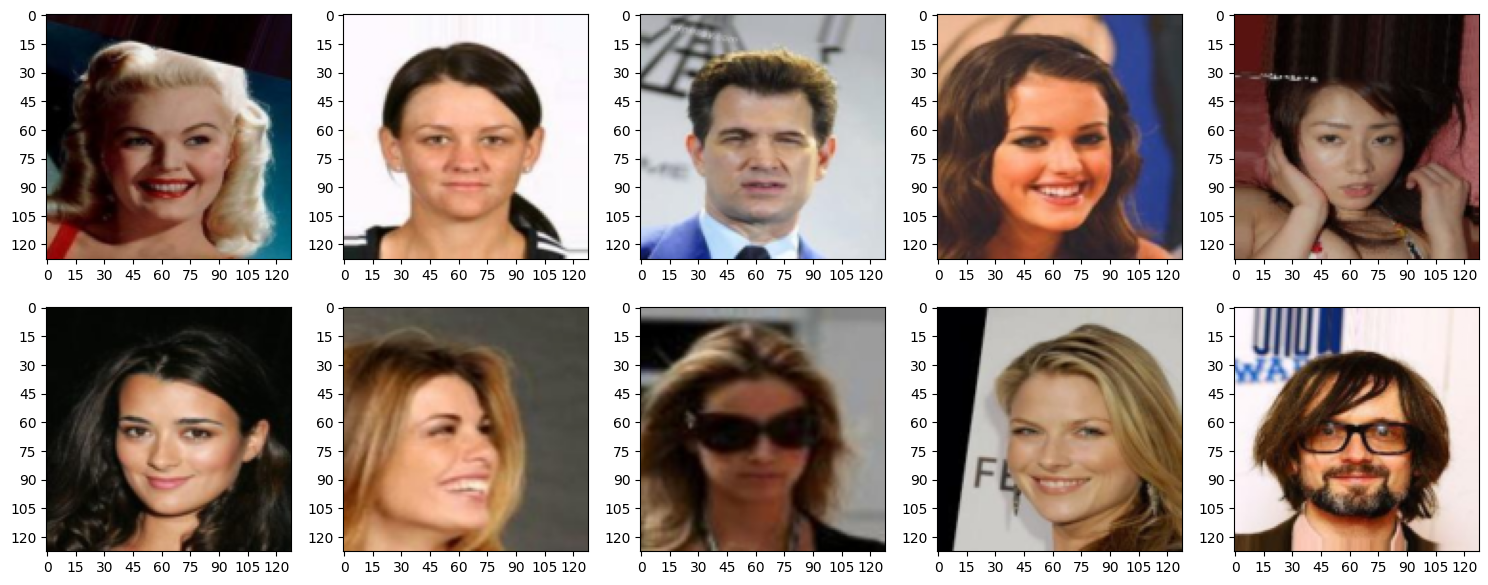

In [17]:
# Example usage with a batch of images
for hr_real, lr_real in train_dataloader:
    show_images(hr_real[:10], lr_real[:10])
    break

## SRGAN Architecture

### Residual Block

This block consists of two convolutional layers with a residual connection to help with the flow of gradients. Residual blocks are important for deep networks as they help to mitigate the vanishing gradient problem.

In [18]:
# Define the Residual Block
class ResidualBlock(nn.Module):
    """
    Residual Block used in the Generator model.

    Args:
        channels (int): Number of input and output channels for the block.
    """
    def __init__(self, channels):
        """
        Initialize the Residual Block.

        Args:
            channels: The number of input and output channels for the block.
        """
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.SiLU(),  
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
        )

    def forward(self, x):
        """
        Forward pass for the Residual Block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor with residual connection.
        """
        # Return the input with the residual connection added to the output of the block
        return x + self.layers(x)

### Generator (SRResNet)

This generator architecture increases the resolution of input images using residual blocks and PixelShuffle layers. The goal is to upscale low-resolution images to high-resolution images.

> ![SRGAN Generator](https://github.com/https-deeplearning-ai/GANs-Public/blob/master/SRGAN-Generator.png?raw=true)
*SRGAN Generator, taken from Figure 4 of [Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802) (Ledig et al. 2017).*

In [19]:
# Define the Generator (SRResNet)
class Generator(nn.Module):
    """
    Generator model for Super-Resolution (SRResNet).

    Args:
        base_channels (int): Number of channels in the first convolutional layer.
        n_ps_blocks (int): Number of PixelShuffle blocks.
        n_res_blocks (int): Number of Residual blocks.
    """
    def __init__(self, base_channels=64, n_ps_blocks=1, n_res_blocks=16):
        """
        Initialize the Generator (SRResNet) model.

        Args:
            base_channels: The number of channels in the first convolutional layer.
            n_ps_blocks: The number of PixelShuffle blocks.
            n_res_blocks: The number of Residual blocks.
        """
        super().__init__()
        self.in_layer = nn.Sequential(
            nn.Conv2d(3, base_channels, kernel_size=9, padding=4),
            nn.SiLU(),  
        )
        res_blocks = [ResidualBlock(base_channels) for _ in range(n_res_blocks)]
        res_blocks += [
            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels),
        ]
        self.res_blocks = nn.Sequential(*res_blocks)
        ps_blocks = []
        for _ in range(n_ps_blocks):
            ps_blocks += [
                nn.Conv2d(base_channels, 4 * base_channels, kernel_size=3, padding=1),
                nn.PixelShuffle(2),
                nn.SiLU(),  
            ]
        self.ps_blocks = nn.Sequential(*ps_blocks)
        self.out_layer = nn.Sequential(
            nn.Conv2d(base_channels, 3, kernel_size=9, padding=4),
            nn.Tanh(),
        )

    def forward(self, x):
        """
        Forward pass for the Generator model.

        Args:
            x (torch.Tensor): Low-resolution input tensor.

        Returns:
            torch.Tensor: High-resolution output tensor.
        """
        x_res = self.in_layer(x)
        x = x_res + self.res_blocks(x_res)
        x = self.ps_blocks(x)
        x = self.out_layer(x)
        return x

### Discriminator

The discriminator's task is to classify images as real or fake, providing feedback to the generator during training. We use a series of convolutional layers and LeakyReLU activations to classify the images.

![SRGAN Generator](https://github.com/https-deeplearning-ai/GANs-Public/blob/master/SRGAN-Discriminator.png?raw=true)
*SRGAN Discriminator, taken from Figure 4 of [Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802) (Ledig et al. 2017).*

In [20]:
# Define the Discriminator
class Discriminator(nn.Module):
    """
    Discriminator model for distinguishing real and fake high-resolution images.

    Args:
        base_channels (int): Number of channels in the first convolutional layer.
        n_blocks (int): Number of convolutional blocks.
    """
    def __init__(self, base_channels=64, n_blocks=6):
        super().__init__()
        self.blocks = [
            nn.Conv2d(3, base_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(base_channels),
            nn.LeakyReLU(0.2, inplace=True),
        ]
        cur_channels = base_channels
        for _ in range(n_blocks):
            self.blocks += [
                nn.Conv2d(cur_channels, 2 * cur_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(2 * cur_channels),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(2 * cur_channels, 2 * cur_channels, kernel_size=3, padding=1, stride=2),
                nn.BatchNorm2d(2 * cur_channels),
                nn.LeakyReLU(0.2, inplace=True),
            ]
            cur_channels *= 2
        self.blocks += [
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(cur_channels, 2 * cur_channels, kernel_size=1, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(2 * cur_channels, 1, kernel_size=1, padding=0),
            nn.Flatten(),
        ]
        self.layers = nn.Sequential(*self.blocks)

    def forward(self, x):
        """
        Forward pass for the Discriminator model.

        Args:
            x (torch.Tensor): Input tensor (image).

        Returns:
            torch.Tensor: Output tensor (real or fake prediction).
        """
        return self.layers(x)

### Loss Functions

The loss function combines three terms:

1. **Content loss**: Measures the difference between high-resolution images and generated images using MSE.
2. **Adversarial loss**: Measures how well the discriminator can distinguish between real and generated images.
3. **Perceptual loss**: Measures the perceptual similarity between real and generated images using features from VGG19.

In [21]:
# Define the Loss class
class Loss(nn.Module):
    """
    Loss function for training the SRGAN model.

    Args:
        device (str): Device to run the loss calculations ('cuda' or 'cpu').
    """
    def __init__(self, device='cuda'):
        super().__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).to(device)
        self.vgg = nn.Sequential(*list(vgg.features)[:-1]).eval()
        for p in self.vgg.parameters():
            p.requires_grad = False

    @staticmethod
    def img_loss(x_real, x_fake):
        """
        Calculate image reconstruction loss (MSE).

        Args:
            x_real (torch.Tensor): Real high-resolution image.
            x_fake (torch.Tensor): Generated high-resolution image.

        Returns:
            torch.Tensor: MSE loss.
        """
        return F.mse_loss(x_real, x_fake)

    def adv_loss(self, x, is_real):
        """
        Calculate adversarial loss.

        Args:
            x (torch.Tensor): Discriminator predictions.
            is_real (bool): Whether the predictions are for real images.

        Returns:
            torch.Tensor: Adversarial loss.
        """
        target = torch.zeros_like(x) if is_real else torch.ones_like(x)
        return F.binary_cross_entropy_with_logits(x, target)

    def vgg_loss(self, x_real, x_fake):
        """
        Calculate perceptual loss using VGG19 features.

        Args:
            x_real (torch.Tensor): Real high-resolution image.
            x_fake (torch.Tensor): Generated high-resolution image.

        Returns:
            torch.Tensor: Perceptual loss.
        """
        return F.mse_loss(self.vgg(x_real), self.vgg(x_fake))

    def forward(self, generator, discriminator, hr_real, lr_real):
        """
        Calculate generator and discriminator losses.

        Args:
            generator (nn.Module): Generator model.
            discriminator (nn.Module): Discriminator model.
            hr_real (torch.Tensor): Real high-resolution images.
            lr_real (torch.Tensor): Low-resolution images.

        Returns:
            tuple: Generator loss, discriminator loss, and generated high-resolution images.
        """
        hr_fake = generator(lr_real)
        fake_preds_for_g = discriminator(hr_fake)
        fake_preds_for_d = discriminator(hr_fake.detach())
        real_preds_for_d = discriminator(hr_real.detach())
        g_loss = (
            0.001 * self.adv_loss(fake_preds_for_g, False) +
            0.006 * self.vgg_loss(hr_real, hr_fake) +
            self.img_loss(hr_real, hr_fake)
        )
        d_loss = 0.5 * (
            self.adv_loss(real_preds_for_d, True) +
            self.adv_loss(fake_preds_for_d, False)
        )
        return g_loss, d_loss, hr_fake

### Evaluation Metrics: PSNR and SSIM

We use Peak Signal-to-Noise Ratio (PSNR) and Structural Similarity Index Measure (SSIM) to evaluate the quality of the generated high-resolution images.

In [22]:
# Function to calculate PSNR (Peak Signal-to-Noise Ratio)
def calculate_psnr(img1, img2, max_value=1.0):
    """
    Calculate Peak Signal-to-Noise Ratio (PSNR) between two images.

    Args:
        img1 (torch.Tensor): First image tensor.
        img2 (torch.Tensor): Second image tensor.
        max_value (float): Maximum pixel value (default: 1.0).

    Returns:
        float: PSNR value in decibels (dB).
    """
    # Convert tensor images to numpy arrays and calculate MSE
    img1 = img1.detach().cpu().numpy()  # Detach from computation graph and convert to numpy
    img2 = img2.detach().cpu().numpy()  # Detach from computation graph and convert to numpy
    mse = np.mean((img1 - img2) ** 2)
    
    # Avoid division by zero
    if mse == 0:
        return 100  # If MSE is 0, return a PSNR of 100
    psnr = 10 * log10((max_value ** 2) / mse)  # Calculate PSNR
    return psnr

# Function to calculate SSIM (Structural Similarity Index)
def calculate_ssim(img1, img2, win_size=3, data_range=2):
    """
    Calculate Structural Similarity Index (SSIM) between two images.

    Args:
        img1 (torch.Tensor): First image tensor.
        img2 (torch.Tensor): Second image tensor.
        win_size (int): Window size for SSIM calculation (default: 3).
        data_range (float): Data range of the images (default: 2).

    Returns:
        float: SSIM value.
    """
    # Convert tensor images to numpy arrays
    img1 = img1.detach().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format for SSIM
    img2 = img2.detach().cpu().numpy().transpose(1, 2, 0)
    
    # Compute SSIM with a smaller window size (e.g., 3 or 5)
    return ssim(img1, img2, win_size=win_size, multichannel=True, data_range=data_range)

### Training the SRGAN

Training loop for both the generator and the discriminator. The optimizer used is AdamW, and we combine adversarial and perceptual loss for training.

In [23]:
def show_tensor_images(image_tensor, num_images=4, title=None):
    """
    Displays a grid of images from a tensor batch in [-1, 1] range.

    Args:
        image_tensor (torch.Tensor): Batch of images (B, C, H, W) normalized to [-1, 1].
        num_images (int): Number of images to display (default: 4).
        title (str, optional): Optional title for the plot.
    """
    # Convert from [-1, 1] to [0, 1] for visualization
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()[:num_images]
    image_grid = make_grid(image_unflat, nrow=num_images, padding=2)

    plt.figure(figsize=(2 * num_images, 2))
    if title:
        plt.title(title, fontsize=12)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
# Define the srresnet_training function
def train_srresnet(generator, dataloader, device, lr=1e-4, total_steps=30_000, display_step=1000, patience=5, min_improvement=0.1, warmup_steps=10_000):
    """
    Pretrain the generator (SRResNet) using only MSE loss, with PSNR/SSIM monitoring,
    early stopping and learning rate decay.

    Args:
        generator (nn.Module): The generator model.
        dataloader (DataLoader): Dataloader for training data.
        device (str): 'cuda' or 'cpu'.
        lr (float): Initial learning rate.
        total_steps (int): Total steps to train.
        display_step (int): Step interval for displaying metrics.
        patience (int): Early stopping patience.
        min_improvement (float): Minimum PSNR improvement to reset patience.
        warmup_steps (int): Steps before early stopping is considered.
    """
    generator = generator.to(device).train()
    optimizer = torch.optim.AdamW(generator.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step: 0.1 if step >= total_steps // 2 else 1.0)

    loss_fn = nn.MSELoss()

    best_psnr = -float("inf")
    patience_counter = 0

    cur_step = 0
    mean_loss = 0.0
    mean_psnr = 0.0
    mean_ssim = 0.0

    pbar = tqdm(total=total_steps, desc="Pretraining SRResNet")

    while cur_step < total_steps:
        for hr_real, lr_real in dataloader:
            if cur_step >= total_steps:
                break

            hr_real = hr_real.to(device)
            lr_real = lr_real.to(device)

            hr_fake = generator(lr_real)
            loss = loss_fn(hr_fake, hr_real)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            mean_loss += loss.item() / display_step

            # Metrics on first image
            psnr_value = calculate_psnr(hr_real[0], hr_fake[0])
            ssim_value = calculate_ssim(hr_real[0], hr_fake[0], win_size=3, data_range=2)
            mean_psnr += psnr_value / display_step
            mean_ssim += ssim_value / display_step

            # Display progress
            if cur_step % display_step == 0 and cur_step > 0:
                tqdm.write(f"Step {cur_step}: MSE Loss: {mean_loss:.5f}")
                tqdm.write(f"→ PSNR: {mean_psnr:.2f} dB, SSIM: {mean_ssim:.4f}")
                mean_loss = mean_psnr = mean_ssim = 0.0

            # Early stopping after warmup
            if cur_step >= warmup_steps:
                if psnr_value > best_psnr + min_improvement:
                    best_psnr = psnr_value
                    patience_counter = 0
                else:
                    patience_counter += 1
                if patience_counter >= patience:
                    tqdm.write(f"🛑 Early stopping at step {cur_step} — no improvement in PSNR.")
                    torch.save(generator.state_dict(), "models/srgan/srresnet_pretrained.pth")
                    print("✅ SRResNet saved before early stopping.")
                    return

            cur_step += 1
            pbar.update(1)

    pbar.close()
    torch.save(generator.state_dict(), "models/srgan/srresnet_pretrained.pth")
    print("✅ Pretrained SRResNet saved after full training.")

In [25]:
# Define the training function
def train_srgan(generator, discriminator, dataloader, device, lr=1e-4, total_steps=30_000, display_step=1000, patience=5, min_improvement=0.1, warmup_steps=10000):
    """
    Train SRGAN model using perceptual, adversarial and MSE loss with PSNR and SSIM monitoring and image visualization.

    Args:
        generator (nn.Module): Pretrained generator model.
        discriminator (nn.Module): Discriminator model.
        dataloader (DataLoader): Dataloader for training data.
        device (str): Computation device.
        lr (float): Learning rate.
        total_steps (int): Total steps to train.
        display_step (int): Interval to log and visualize.
        patience (int): Early stopping patience.
        min_improvement (float): Min PSNR improvement to reset patience.
        warmup_steps (int): Steps before early stopping is considered.
    """
    generator = generator.to(device).train()
    discriminator = discriminator.to(device).train()
    loss_fn = Loss(device=device)

    g_optimizer = torch.optim.AdamW(generator.parameters(), lr=lr)
    d_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=lr)

    g_scheduler = torch.optim.lr_scheduler.LambdaLR(g_optimizer, lambda step: 0.1 if step >= total_steps // 2 else 1.0)
    d_scheduler = torch.optim.lr_scheduler.LambdaLR(d_optimizer, lambda step: 0.1 if step >= total_steps // 2 else 1.0)

    best_psnr = -float("inf")
    patience_counter = 0

    cur_step = 0
    mean_g_loss = 0.0
    mean_d_loss = 0.0
    mean_psnr = 0.0
    mean_ssim = 0.0

    pbar = tqdm(total=total_steps, desc="Training SRGAN")

    while cur_step < total_steps:
        for hr_real, lr_real in dataloader:
            if cur_step >= total_steps:
                break

            hr_real = hr_real.to(device)
            lr_real = lr_real.to(device)

            g_loss, d_loss, hr_fake = loss_fn(generator, discriminator, hr_real, lr_real)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            g_scheduler.step()
            d_scheduler.step()

            mean_g_loss += g_loss.item() / display_step
            mean_d_loss += d_loss.item() / display_step

            psnr_value = calculate_psnr(hr_real[0], hr_fake[0])
            ssim_value = calculate_ssim(hr_real[0], hr_fake[0], win_size=3, data_range=2)
            mean_psnr += psnr_value / display_step
            mean_ssim += ssim_value / display_step

            if cur_step % display_step == 0 and cur_step > 0:
                tqdm.write(f"Step {cur_step}: G_loss: {mean_g_loss:.5f}, D_loss: {mean_d_loss:.5f}")
                tqdm.write(f"→ PSNR: {mean_psnr:.2f} dB, SSIM: {mean_ssim:.4f}")
                mean_g_loss = mean_d_loss = mean_psnr = mean_ssim = 0.0

                # Visualize: LR, SR, HR (same as original paper)
                show_tensor_images(lr_real, title=f"Low Resolution — Step {cur_step}")
                show_tensor_images(hr_fake.to(hr_real.dtype), title=f"Super Resolution — Step {cur_step}")
                show_tensor_images(hr_real, title=f"High Resolution — Step {cur_step}")

            # Early stopping based on PSNR
            if cur_step >= warmup_steps:
                if psnr_value > best_psnr + min_improvement:
                    best_psnr = psnr_value
                    patience_counter = 0
                else:
                    patience_counter += 1
                if patience_counter >= patience:
                    tqdm.write(f"🛑 Early stopping at step {cur_step} due to no improvement in PSNR.")
                    # Save models on early stop
                    torch.save(generator.state_dict(), "models/srgan/srgenerator.pth")
                    torch.save(discriminator.state_dict(), "models/srgan/srdiscriminator.pth")
                    print("✅ Models saved after early stopping.")
                    return

            cur_step += 1
            pbar.update(1)

    pbar.close()
    # Save final models after completing training
    torch.save(generator.state_dict(), "models/srgan/srgenerator.pth")
    torch.save(discriminator.state_dict(), "models/srgan/srdiscriminator.pth")
    print("✅ SRGAN training completed and models saved.")

### Start Training

Initialize and start training the model.

In [26]:
# Phase 1: Pretrain the generator (SRResNet)
generator = Generator(n_res_blocks=16, n_ps_blocks=1)
train_srresnet(generator, train_dataloader, device)

Pretraining SRResNet:   0%|          | 0/30000 [00:00<?, ?it/s]

Step 1000: MSE Loss: 0.01020
→ PSNR: 21.86 dB, SSIM: 0.8407
Step 2000: MSE Loss: 0.00300
→ PSNR: 25.61 dB, SSIM: 0.9302
Step 3000: MSE Loss: 0.00234
→ PSNR: 26.69 dB, SSIM: 0.9431
Step 4000: MSE Loss: 0.00201
→ PSNR: 27.42 dB, SSIM: 0.9505
Step 5000: MSE Loss: 0.00182
→ PSNR: 28.00 dB, SSIM: 0.9574
Step 6000: MSE Loss: 0.00167
→ PSNR: 28.30 dB, SSIM: 0.9592
Step 7000: MSE Loss: 0.00151
→ PSNR: 28.75 dB, SSIM: 0.9639
Step 8000: MSE Loss: 0.00142
→ PSNR: 29.12 dB, SSIM: 0.9660
Step 9000: MSE Loss: 0.00140
→ PSNR: 29.20 dB, SSIM: 0.9662
Step 10000: MSE Loss: 0.00131
→ PSNR: 29.42 dB, SSIM: 0.9686
🛑 Early stopping at step 10013 — no improvement in PSNR.
✅ SRResNet saved before early stopping.


Training SRGAN:   0%|          | 0/30000 [00:00<?, ?it/s]

Step 1000: G_loss: 0.00191, D_loss: 0.26310
→ PSNR: 29.05 dB, SSIM: 0.9648


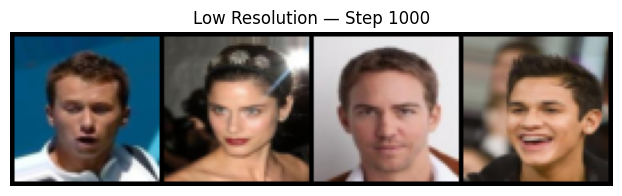

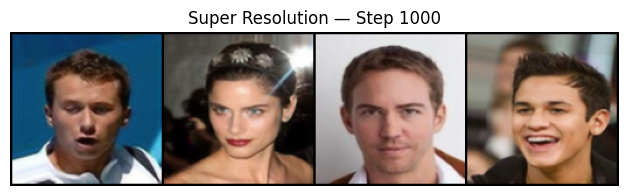

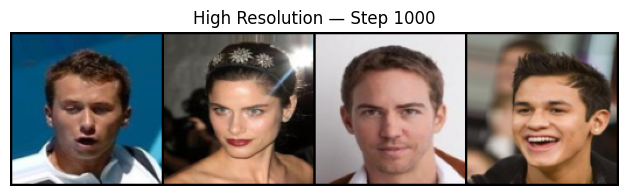

Step 2000: G_loss: 0.00170, D_loss: 0.02999
→ PSNR: 28.85 dB, SSIM: 0.9629


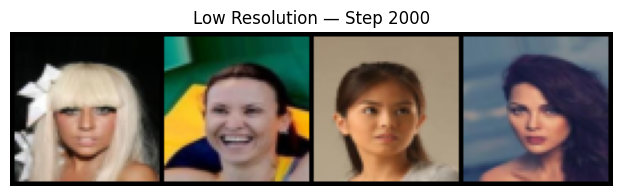

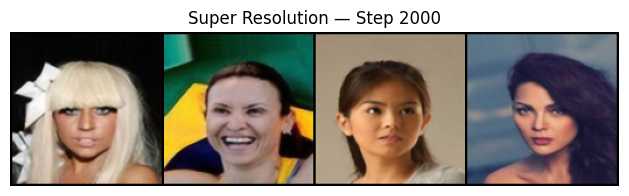

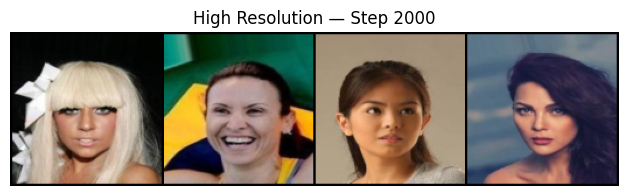

Step 3000: G_loss: 0.00150, D_loss: 0.01337
→ PSNR: 29.39 dB, SSIM: 0.9675


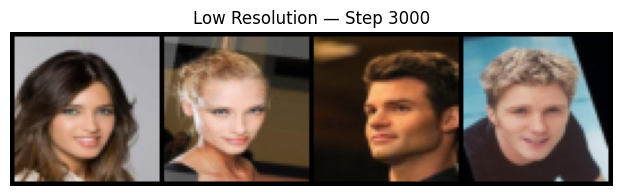

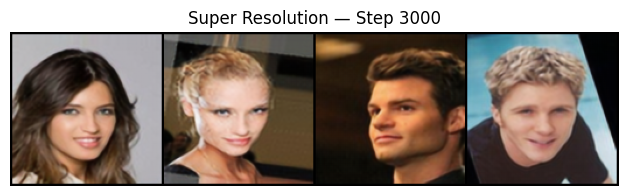

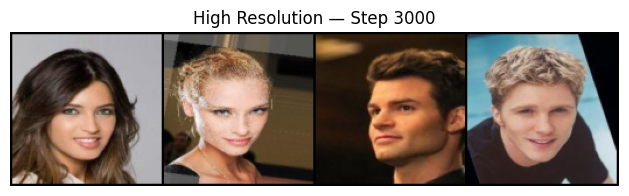

Step 4000: G_loss: 0.00144, D_loss: 0.00814
→ PSNR: 29.61 dB, SSIM: 0.9696


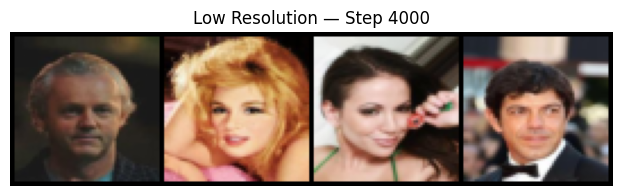

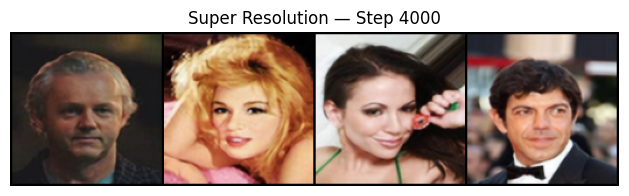

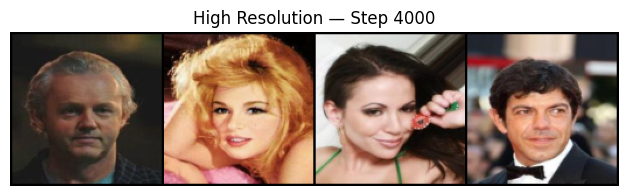

Step 5000: G_loss: 0.00145, D_loss: 0.01633
→ PSNR: 29.55 dB, SSIM: 0.9685


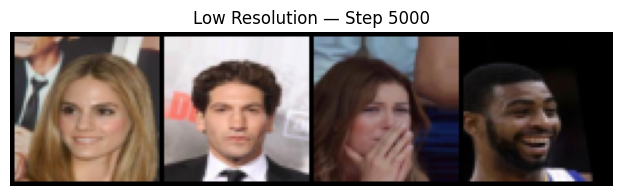

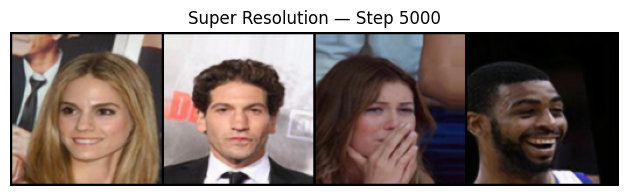

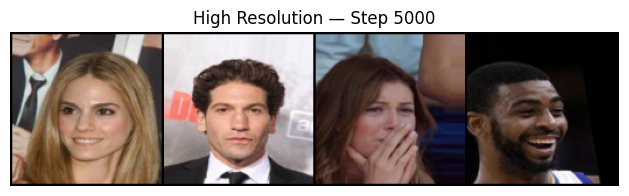

Step 6000: G_loss: 0.00154, D_loss: 0.00646
→ PSNR: 29.34 dB, SSIM: 0.9669


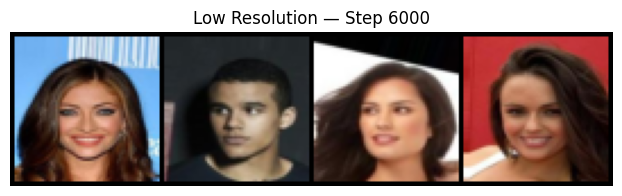

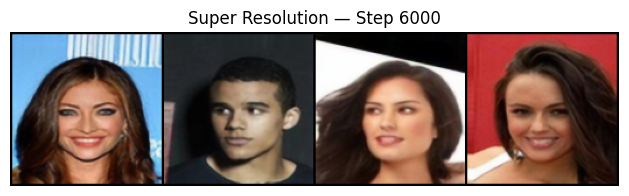

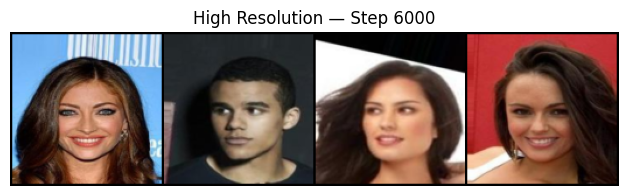

Step 7000: G_loss: 0.00140, D_loss: 0.00231
→ PSNR: 29.58 dB, SSIM: 0.9695


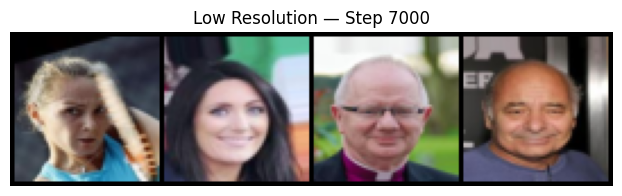

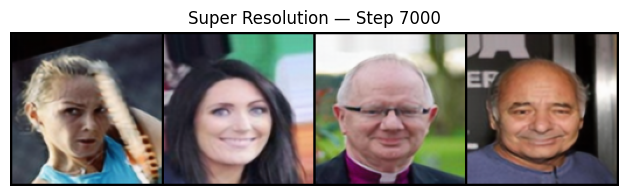

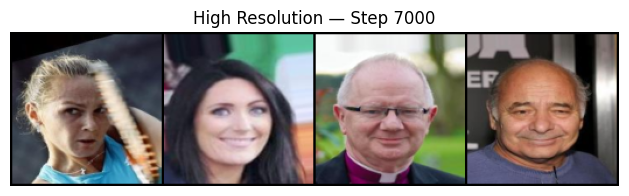

Step 8000: G_loss: 0.00171, D_loss: 0.01557
→ PSNR: 28.87 dB, SSIM: 0.9607


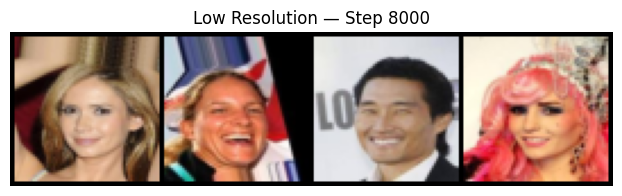

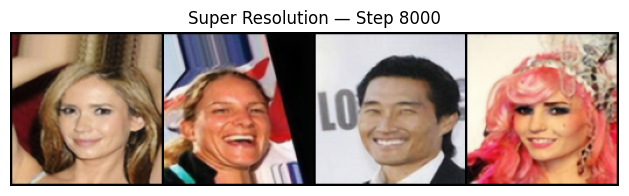

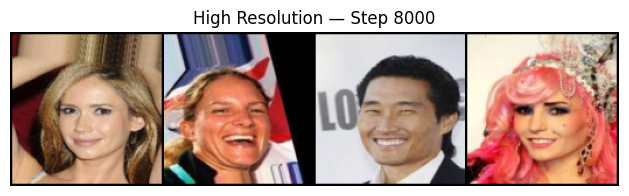

Step 9000: G_loss: 0.00141, D_loss: 0.00567
→ PSNR: 29.69 dB, SSIM: 0.9692


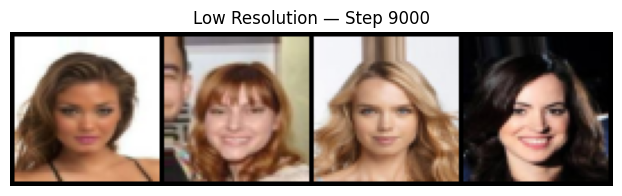

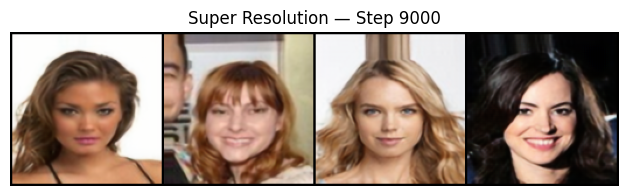

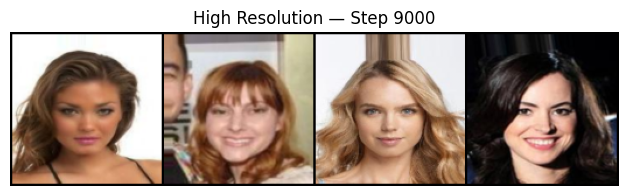

Step 10000: G_loss: 0.00136, D_loss: 0.00425
→ PSNR: 29.70 dB, SSIM: 0.9697


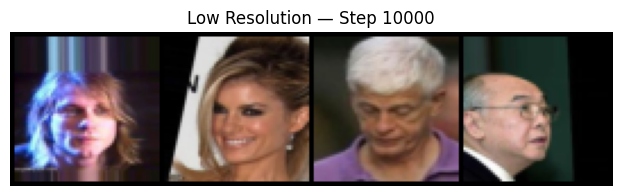

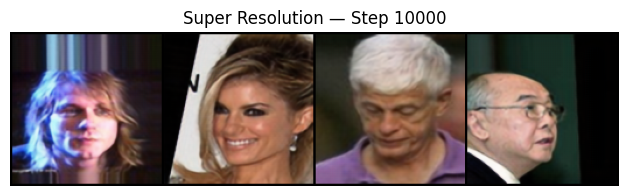

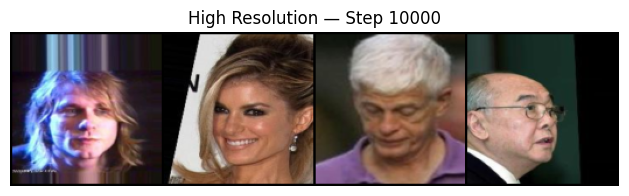

🛑 Early stopping at step 10008 due to no improvement in PSNR.
✅ Models saved after early stopping.


In [27]:
# Phase 2: Train the full SRGAN
generator.load_state_dict(torch.load("models/srgan/srresnet_pretrained.pth"))
discriminator = Discriminator(n_blocks=1, base_channels=64)
train_srgan(generator, discriminator, train_dataloader, device)

In [28]:
generator = Generator().to(device)
generator.load_state_dict(torch.load('models/srgan/srgenerator.pth', map_location=device))
generator.eval()

Generator(
  (in_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): SiLU()
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [29]:
def evaluate(generator, test_loader, device):
    """
    Evaluate the generator model on the test dataset using PSNR and SSIM.

    Args:
        generator (nn.Module): Generator model.
        test_loader (DataLoader): Dataloader for the test dataset.
        device (str): 'cuda' or 'cpu'.

    Returns:
        tuple: Average PSNR and SSIM over the full dataset.
    """
    generator.eval()
    total_psnr = 0.0
    total_ssim = 0.0
    num_images = 0

    with torch.no_grad():
        for hr_real, lr_real in tqdm(test_loader, desc="Evaluating"):
            hr_real = hr_real.to(device)
            lr_real = lr_real.to(device)
            hr_fake = generator(lr_real)

            batch_size = hr_real.size(0)
            for i in range(batch_size):
                psnr = calculate_psnr(hr_real[i], hr_fake[i])
                ssim = calculate_ssim(hr_real[i], hr_fake[i], win_size=3, data_range=2)
                total_psnr += psnr
                total_ssim += ssim
                num_images += 1

    avg_psnr = total_psnr / num_images
    avg_ssim = total_ssim / num_images

    print(f"\nEvaluation Results — PSNR: {avg_psnr:.2f} dB | SSIM: {avg_ssim:.4f}")
    return avg_psnr, avg_ssim

In [30]:
# Evaluate on the test set
evaluate(generator, test_dataloader, device)

Evaluating:   0%|          | 0/2533 [00:00<?, ?it/s]


Evaluation Results — PSNR: 30.18 dB | SSIM: 0.9734


(30.183436979169002, np.float64(0.973367465857743))

In [33]:
def visualize_samples(generator, test_loader, device):
    """
    Visualize and compare low-resolution, super-resolution, and high-resolution images
    including PSNR and SSIM metrics for each example.

    Args:
        generator (nn.Module): The trained generator model.
        test_loader (DataLoader): Dataloader for the test dataset.
        device (str): Computation device ('cuda' or 'cpu').

    Displays:
        A grid with 5 images per row: Low-Res (LR), Super-Res (SR), High-Res (HR).
        PSNR and SSIM values are shown on the Super-Res row.
    """
    def denormalize(tensor):
        """
        Denormalizes a tensor from [-1, 1] to [0, 1].
        """
        return tensor * 0.5 + 0.5

    generator.eval()
    with torch.no_grad():
        for hr_real, lr_real in test_loader:
            lr_real = lr_real.to(device)
            sr_fake = generator(lr_real)
            num_images = min(5, lr_real.size(0))  # Display up to 5 images

            fig, axs = plt.subplots(3, num_images, figsize=(3 * num_images, 9))

            for i in range(num_images):
                # Convert tensors to NumPy images for visualization
                lr_img = denormalize(lr_real[i].cpu()).permute(1, 2, 0).numpy()
                sr_img = denormalize(sr_fake[i].cpu()).permute(1, 2, 0).numpy()
                hr_img = denormalize(hr_real[i].cpu()).permute(1, 2, 0).numpy()

                # Compute PSNR and SSIM for current image
                psnr = calculate_psnr(hr_real[i], sr_fake[i])
                ssim = calculate_ssim(hr_real[i], sr_fake[i], win_size=3, data_range=2)

                # Plot Low-Resolution image
                axs[0, i].imshow(np.clip(lr_img, 0, 1))
                axs[0, i].set_title("Low Resolution")
                axs[0, i].axis("off")

                # Plot Super-Resolution image with PSNR/SSIM in title
                axs[1, i].imshow(np.clip(sr_img, 0, 1))
                axs[1, i].set_title(f"Super Resolution\nPSNR: {psnr:.1f} dB\nSSIM: {ssim:.2f}")
                axs[1, i].axis("off")

                # Plot High-Resolution image
                axs[2, i].imshow(np.clip(hr_img, 0, 1))
                axs[2, i].set_title("High Resolution")
                axs[2, i].axis("off")

            plt.tight_layout()
            plt.show()
            break  # Show only one batch

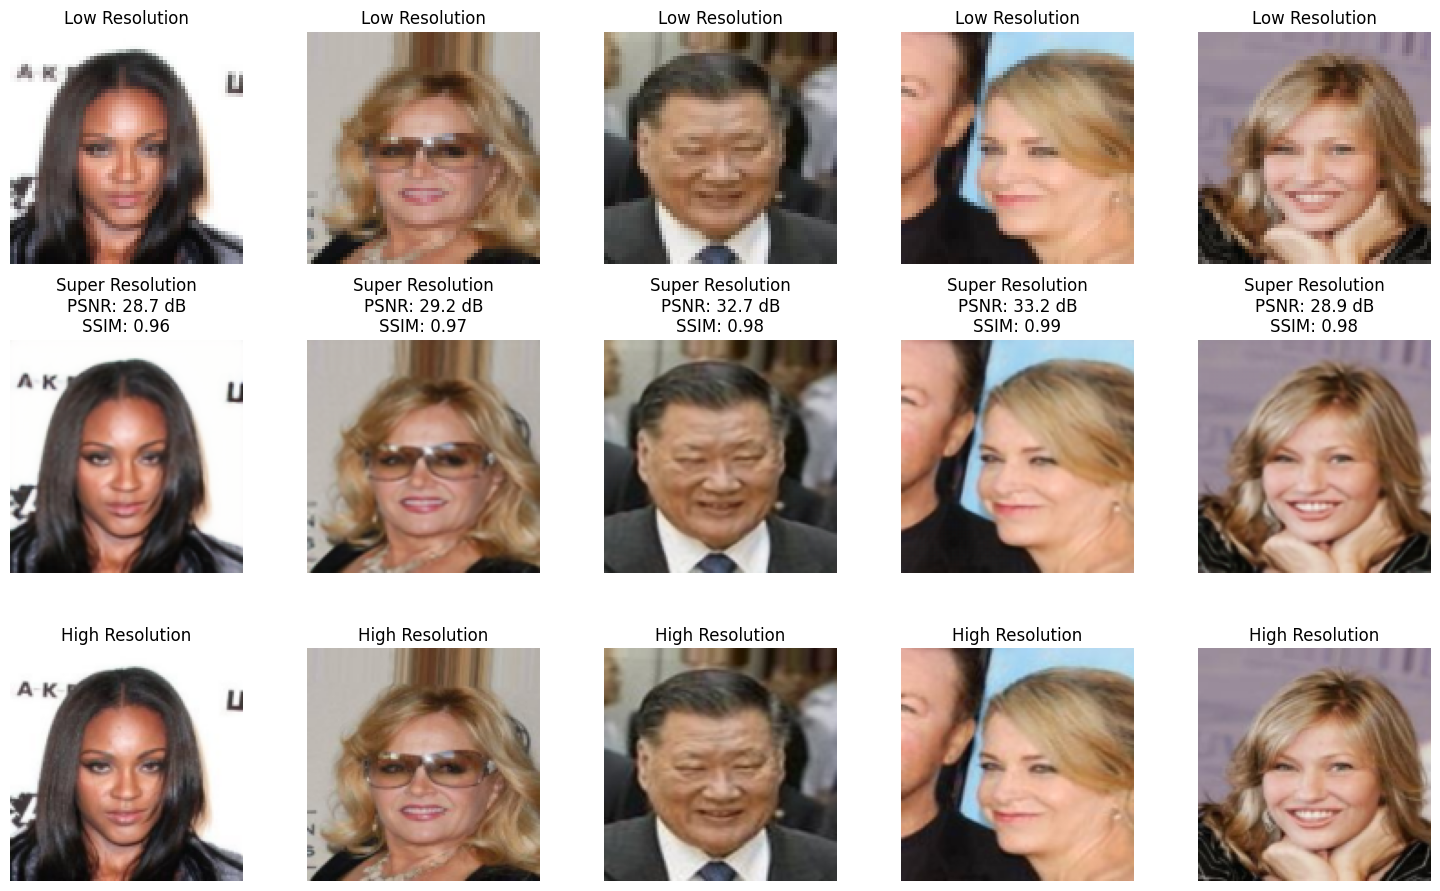

In [34]:
# Display example
visualize_samples(generator, test_dataloader, device)

## Citation

```bibtex
@inproceedings{liu2015faceattributes,
  title = {Deep Learning Face Attributes in the Wild},
  author = {Liu, Ziwei and Luo, Ping and Wang, Xiaogang and Tang, Xiaoou},
  booktitle = {Proceedings of International Conference on Computer Vision (ICCV)},
  month = {December},
  year = {2015} 
}

```bibtex
@misc{ledig2017photorealisticsingleimagesuperresolution,
      title={Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network}, 
      author={Christian Ledig and Lucas Theis and Ferenc Huszar and Jose Caballero and Andrew Cunningham and Alejandro Acosta and Andrew Aitken and Alykhan Tejani and Johannes Totz and Zehan Wang and Wenzhe Shi},
      year={2017},
      eprint={1609.04802},
      archivePrefix={arXiv},
      primaryClass={cs.CV},
      url={https://arxiv.org/abs/1609.04802}, 
}